ECB Simulation Progress: 100%|█████████████| 5000/5000 [00:16<00:00, 302.65it/s]


ECB execution time: 16.53 seconds


UCB Simulation Progress: 100%|█████████████| 5000/5000 [00:19<00:00, 253.18it/s]
/var/folders/kc/bsxv4hyn11s39gynyl4bzt9c0000gn/T/ipykernel_52067/1937361259.py:137: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=True, kde=True, label=f"{algorithm_name} Least-square", color=sns.color_palette()[0], kde_kws={'linewidth': 3.0})


UCB execution time: 19.75 seconds


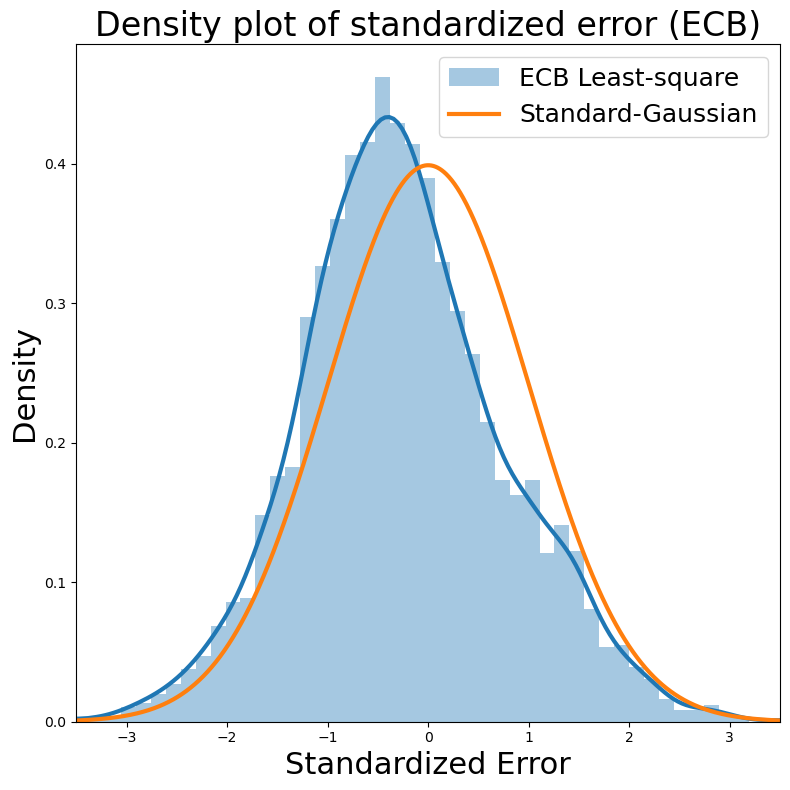

/var/folders/kc/bsxv4hyn11s39gynyl4bzt9c0000gn/T/ipykernel_52067/1937361259.py:137: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=True, kde=True, label=f"{algorithm_name} Least-square", color=sns.color_palette()[0], kde_kws={'linewidth': 3.0})


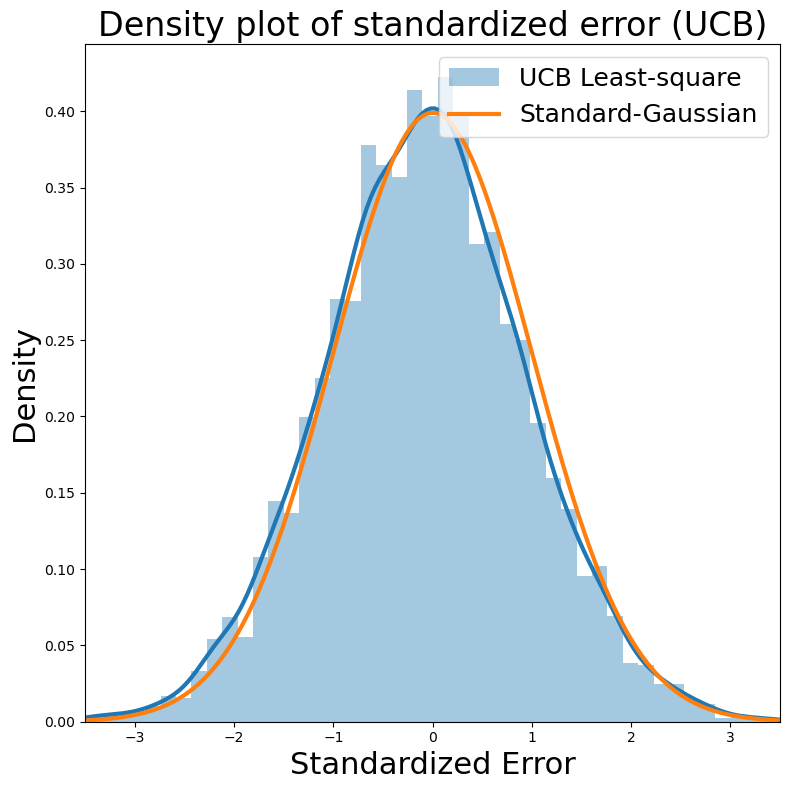

ECB Summary:
Mean arm 2 ratio: 0.4972
Std arm 2 ratio: 0.3859

UCB Summary:
Mean arm 2 ratio: 0.5017
Std arm 2 ratio: 0.1117


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import time
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(1234)

# Trial repetitions and trial size
R = 5000 # Number of repeat
T = 1000 # Total number of arm-pulls
K = 2
ECB_epsilon = 0.1

# Reward and noise parameters
noise_param = 1.0
reward_means = np.array([0.3, 0.3])
reward_vars = np.array([1/(2*noise_param + 1.0)] * K)

# Prior parameters
mu0 = 0.4
var0 = 1/(2*noise_param + 1.0)

# Epsilon-greedy policy
def ECB(mu_post, var_post, epsilon=ECB_epsilon):
    use_cb = np.random.binomial(1, 1.0-epsilon)
    if use_cb:
        arm = np.argmax(mu_post)
    else:
        arm = np.random.choice(range(K))
    return arm

# Gather data for ECB
ecb_least_squares_errors = []
ecb_arm2_ratios = []

# Start the timer for ECB
ecb_start_time = time.time()

# Use tqdm for the progress bar
for r in tqdm(range(R), desc="ECB Simulation Progress"):
    mu_post = np.repeat(mu0, K)
    var_post = np.repeat(var0, K)

    rewards = []
    arms_selected = []

    for t in range(T):
        if t < K:
            arm = t
        else:
            arm = ECB(mu_post, var_post, epsilon=ECB_epsilon)

        reward = 2*np.random.beta(noise_param, noise_param) - 1.0 + reward_means[arm]

        new_var = 1.0 / (1.0 / var_post[arm] + 1.0 / reward_vars[arm])
        mu_post[arm] = (mu_post[arm] / var_post[arm] + reward / reward_vars[arm]) * new_var
        var_post[arm] = new_var

        rewards.append(reward)
        arms_selected.append(arm)

    # Compute least squares estimator for arm 2 (index 1)
    rewards_arm_2 = np.array([rewards[i] for i in range(T) if arms_selected[i] == 1])
    n_arm_2 = len(rewards_arm_2)
    ecb_arm2_ratios.append(n_arm_2 / T)
    if n_arm_2 > 0:
        least_squares_estimate = np.mean(rewards_arm_2)
        true_mean = reward_means[1]
        std_error = np.std(rewards_arm_2) / np.sqrt(n_arm_2)
        standardized_error = (least_squares_estimate - true_mean) / std_error
        ecb_least_squares_errors.append(standardized_error)

# End the timer for ECB
ecb_end_time = time.time()

# Calculate the execution time for ECB
ecb_execution_time = ecb_end_time - ecb_start_time
print(f"ECB execution time: {ecb_execution_time:.2f} seconds")

# UCB algorithm
def UCB(t, n_a, X_a):
    return X_a + np.sqrt(2 * np.log(t) / n_a)

# Gather data for UCB
ucb_least_squares_errors = []
ucb_arm2_ratios = []

# Start the timer for UCB
ucb_start_time = time.time()

# Use tqdm for the progress bar
for r in tqdm(range(R), desc="UCB Simulation Progress"):
    rewards = []
    arms_selected = []
    n_a = np.zeros(K)
    X_a = np.zeros(K)

    for t in range(T):
        if t < K:
            arm = t
        else:
            ucb_values = UCB(t, n_a, X_a)
            arm = np.argmax(ucb_values)

        reward = 2*np.random.beta(noise_param, noise_param) - 1.0 + reward_means[arm]

        n_a[arm] += 1
        X_a[arm] = ((n_a[arm] - 1) * X_a[arm] + reward) / n_a[arm]

        rewards.append(reward)
        arms_selected.append(arm)

    # Compute least squares estimator for arm 2 (index 1)
    rewards_arm_2 = np.array([rewards[i] for i in range(T) if arms_selected[i] == 1])
    n_arm_2 = len(rewards_arm_2)
    ucb_arm2_ratios.append(n_arm_2 / T)
    if n_arm_2 > 0:
        least_squares_estimate = np.mean(rewards_arm_2)
        true_mean = reward_means[1]
        std_error = np.std(rewards_arm_2) / np.sqrt(n_arm_2)
        standardized_error = (least_squares_estimate - true_mean) / std_error
        ucb_least_squares_errors.append(standardized_error)

# End the timer for UCB
ucb_end_time = time.time()

# Calculate the execution time for UCB
ucb_execution_time = ucb_end_time - ucb_start_time
print(f"UCB execution time: {ucb_execution_time:.2f} seconds")

# Plotting function
def plot_density(data, algorithm_name, filename):
    plt.figure(figsize=(8, 8))
    sns.distplot(data, hist=True, kde=True, label=f"{algorithm_name} Least-square", color=sns.color_palette()[0], kde_kws={'linewidth': 3.0})

    x = np.linspace(-3.5, 3.5, 1000)
    y = norm.pdf(x)
    plt.plot(x, y, label="Standard-Gaussian", color=sns.color_palette()[1], linewidth=3.0)

    plt.legend(fontsize=18, loc='upper right')
    plt.title(f'Density plot of standardized error ({algorithm_name})', fontsize=24)
    plt.xlabel('Standardized Error', fontsize=22)
    plt.ylabel('Density', fontsize=22)
    plt.xlim(-3.5, 3.5)
    plt.tight_layout()
    
    plt.savefig(filename, format='pdf', dpi=300, bbox_inches='tight')

    
    plt.show()

# Plot density for ECB
plot_density(ecb_least_squares_errors, "ECB", "ecb_density_plot.pdf")

# Plot density for UCB
plot_density(ucb_least_squares_errors, "UCB", "ucb_density_plot.pdf")

# Print summary statistics
print("ECB Summary:")
print(f"Mean arm 2 ratio: {np.mean(ecb_arm2_ratios):.4f}")
print(f"Std arm 2 ratio: {np.std(ecb_arm2_ratios):.4f}")

print("\nUCB Summary:")
print(f"Mean arm 2 ratio: {np.mean(ucb_arm2_ratios):.4f}")
print(f"Std arm 2 ratio: {np.std(ucb_arm2_ratios):.4f}")